# Sotkanet indicators

In this notebook we fetch health indicators on municipalities from Sotkanet.

In [1]:
import requests
import pandas as pd
import seaborn as sns

from urllib.parse import urlencode

In [2]:
url = "https://sotkanet.fi/rest/1.1/indicators"
# url = "https://sotkanet.fi/sotkanet/api/"
HEADERS = {
    "User-Agent": "agent"
}

In [3]:
base_url = "https://sotkanet.fi/rest/1.1/json?"
params = {
    "indicator": "3231",
    "years": "2021",
    "genders": "total",
    "format": "json"
}

response = requests.get(base_url, params=params, headers=HEADERS)

In [4]:
# 1. Get list of municipalities (regions)
def get_municipalities():
    url = "https://sotkanet.fi/rest/1.1/regions"
    response = requests.get(url, headers=HEADERS)
    regions = response.json()
    
    # Filter for municipalities (KUNTA in Finnish)
    municipalities = [r for r in regions if r.get('category') == 'KUNTA']
    return pd.DataFrame(municipalities)

# 2. Search health indicators
def search_indicators(keyword="syntymäpaino"):
    url = "https://sotkanet.fi/rest/1.1/indicators"
    response = requests.get(url, headers=HEADERS)
    indicators = response.json()
    
    # Filter by keyword (case-insensitive)
    health_indicators = [i for i in indicators if keyword.lower() in i['title']['fi'].lower()]
    return pd.DataFrame(health_indicators)



def get_indicator_data_mult(indicator_id, years, genders=["total", "male", "female"]):
    base_url = "https://sotkanet.fi/rest/1.1/json"
    
    params = {
        "indicator": indicator_id,
    }
    
    # Add years and genders as repeated parameters
    for year in years:
        params[f"years"] = year
        
    for gender in genders:
        params[f"genders"] = gender
    
    # Manually encode the URL
    url = f"{base_url}?indicator={indicator_id}"
    for year in years:
        url += f"&years={year}"
    for gender in genders:
        url += f"&genders={gender}"
        
    response = requests.get(url, headers=HEADERS)
    
    return response.json()


# 3. Fetch indicator data for municipalities
def get_indicator_data(indicator_id, years=range(2018, 2023)):
    base_url = "https://sotkanet.fi/rest/1.1/json?"
    
    #params = {
    ##    "indicator": indicator_id,
    #    "years": ",".join(map(str, years)),
    ##    "gender": "total",
    #    "format": "json"
    #}

    params = {
        "indicator": indicator_id,
    }
    
    response = requests.get(base_url, params=params, headers=HEADERS)
    return pd.DataFrame(response.json())


In [5]:
municipalities = get_municipalities()
print(f"Found {len(municipalities)} municipalities")

Found 308 municipalities


In [6]:
# Configuration
HEADERS = {"User-Agent": "MunicipalityAnalysis/1.0"}
SOTKANET_BASE = "https://sotkanet.fi/rest/1.1/json?"

def get_sotkanet_data(indicator_ids, years):
    """Fetch data for multiple indicators from Sotkanet"""
    df_list = []
    
    for indicator_id in indicator_ids:
        url = f"{SOTKANET_BASE}indicator={indicator_id}"
        for year in years:
            url += f"&years={year}"
        url += "&genders=total"
        
        response = requests.get(url, headers=HEADERS)
        data = response.json()
        
        # Convert to DataFrame
        temp_df = pd.DataFrame(data)
        temp_df['indicator_id'] = indicator_id
        df_list.append(temp_df)
    
    final_df = pd.concat(df_list, ignore_index=True)
    return final_df


In [7]:
# Selected indicators.

indicators = {
    180: 'Measure of educational level',
    181: 'Unemployed people, as % of labour force',
    # 190: 'Household-dwelling units with children living in overcrowded conditions, as % of all households with children',
    # 191: 'Placements outside the home for those aged 0-17, as % of total population of same age (THL)',
    289: 'Heavy drinking at least once a month, as % of all pupils in 8th and 9th year of comprehensive school',
    306: 'Disability pension recipients aged 25-64, as % of total population of the same age',
    493: 'Social assistance, recipient persons during year, as % of total population',
    3105: 'Alcohol mortality per 100 000 inhabitant',
    3169: 'Parturients who smoked during pregnancy, % of parturients',
    3113: 'Offences against life and health recorded by the police per 1000 inhabitants',
    # 3219: 'Those aged 17 - 24 not in education or training, as % of total population of same age',
    3071: 'Persons who are difficult to employ (structural unemployment), as % of persons aged 15 - 64',
    3076: 'Voting turnout in municipal elections, %',
    # 4404: 'Daily smokers (%)'
    # 5333: 'Municipality employs a designated expert, planning officer or similar to coordinate health and welfare promotion'
    # 5338: 'Performance indicator average (health and welfare coefficient)'
}

years = list(range(1990, 2024))

In [21]:
[print(f"Indicator {k}: {v}") for (k, v) in indicators.items()];

Indicator 180: Measure of educational level
Indicator 181: Unemployed people, as % of labour force
Indicator 289: Heavy drinking at least once a month, as % of all pupils in 8th and 9th year of comprehensive school
Indicator 306: Disability pension recipients aged 25-64, as % of total population of the same age
Indicator 493: Social assistance, recipient persons during year, as % of total population
Indicator 3105: Alcohol mortality per 100 000 inhabitant
Indicator 3169: Parturients who smoked during pregnancy, % of parturients
Indicator 3113: Offences against life and health recorded by the police per 1000 inhabitants
Indicator 3071: Persons who are difficult to employ (structural unemployment), as % of persons aged 15 - 64
Indicator 3076: Voting turnout in municipal elections, %


In [8]:
data = get_sotkanet_data(indicators, years)

In [9]:
data.dtypes

indicator         int64
region            int64
year              int64
gender           object
value           float64
indicator_id      int64
absValue        float64
dtype: object

In [10]:
sotka_corr = \
    (data[["indicator", "year", "value"]]
     .pivot_table(
        index=["year"], 
        columns="indicator",
        values="value")
     .corr())

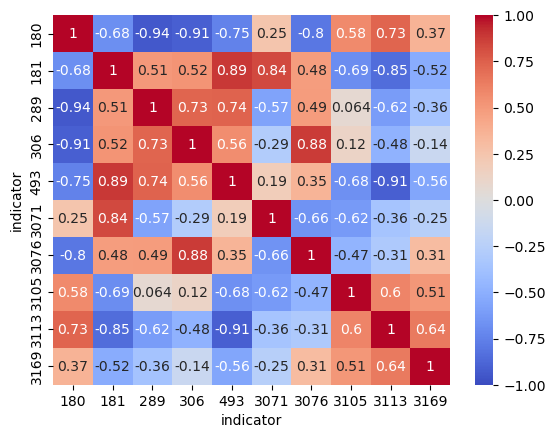

In [17]:
sns.heatmap(sotka_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=1, yticklabels=1);

In [12]:
# Get current municipality codes (KUNTA regions)
def get_municipality_codes():
    url = "https://sotkanet.fi/rest/1.1/regions"
    response = requests.get(url, headers=HEADERS)
    regions = pd.DataFrame(response.json())
    return regions[regions['category'] == 'KUNTA'][['code', 'title']]

municipalities = get_municipality_codes()
municipalities['code'] = municipalities['code'].astype('int')

In [13]:
# Merge with data
final_data = data.merge(
    municipalities, 
    left_on='region', 
    right_on='code',
    how='left'
)

final_data = final_data.dropna(subset=['title'])

# final_data = final_data.rename(columns={'title': 'municipality_name'})
# final_data = final_data[['code', 'municipality_name', 'year', 'indicator_id', 'value']]

In [14]:
# get the municipality name

final_data['municipality'] = final_data.title.map(lambda x: x['fi'])

In [15]:
total_migri = pd.read_csv("data/total_binned_mun_migri.csv", index_col=0)

In [16]:
print(f"Missing Sotkanet data as compared to the Statistics Finland municipality migration dataset.")

set(total_migri.Arrival.unique()).difference(
    set(final_data.municipality.unique())
)

# len(total_migri.Arrival.unique())

Missing Sotkanet data as compared to the Statistics Finland municipality migration dataset.


{'Alavus',
 'Eura',
 'Hollola',
 'Hyvinkää',
 'Hämeenlinna',
 'Iisalmi',
 'Jakobstad',
 'Janakkala',
 'Kajaani',
 'Kangasala',
 'Kankaanpää',
 'Kemi',
 'Kerava',
 'Kontiolahti',
 'Korsholm',
 'Kouvola',
 'Laukaa',
 'Lempäälä',
 'Liperi',
 'Loviisa',
 'Mariehamn',
 'Naantali',
 'Pargas',
 'Pieksämäki',
 'Porvoo',
 'Raahe',
 'Raisio',
 'Rauma',
 'Riihimäki',
 'Salo',
 'Sastamala',
 'Savonlinna',
 'Seinäjoki',
 'Siilinjärvi',
 'Sipoo',
 'Sotkamo',
 'Tornio',
 'Turku',
 'Tuusula',
 'Ulvila',
 'Uusikaupunki',
 'Valkeakoski',
 'Varkaus',
 'Vihti',
 'Ylöjärvi',
 'Äänekoski'}